In [1]:
import pandas as pd
import os.path
import warnings
warnings.filterwarnings( 'ignore' )

data = pd.read_csv(os.getcwd() + '/steam_games.csv')
print(len(data))


40750


In [2]:
# Remove all invalid games, non english games, and non games
data = data[data['name'].str.contains('', na=False)] 
data = data[data['types'].str.contains('app')]
data = data[data['languages'].str.contains('English', na=False)]

# Replace all null genres and tags with 'Other'
data['genre'] = data['genre'].fillna('Other')
data['genre'] = data['genre'].str.replace(',', ', ')
data['popular_tags'] = data['popular_tags'].fillna('Other')
data['popular_tags'] = data['popular_tags'].str.replace(',', ', ')
data['game_details'] = data['game_details'].fillna('Other')

# Replace all no review games with 'Mixed'
data['all_reviews'] = data['all_reviews'].fillna('Mixed')

# Change reviews from strings to numerical values
def check_tuple(tuple_value):
    if 'overhwelmingly positive' in tuple_value.lower():
        return 4
    elif 'very positive' in tuple_value.lower():
        return 3
    elif 'mostly positive' in tuple_value.lower():
        return 1
    elif 'mixed' in tuple_value.lower():
        return 0
    elif 'overwhelmingly negative' in tuple_value.lower():
        return -4
    elif 'very negative' in tuple_value.lower():
        return -3
    elif 'mostly negative' in tuple_value.lower():
        return -1
    elif 'negative' in tuple_value.lower():
        return -2
    elif 'positive' in tuple_value.lower():
        return 2
    else:
        return 0
      
def check_tuple2(tuple_value):
    if 'overhwelmingly positive' in tuple_value.lower():
        return 'Overhwelmingly Positive'
    elif 'very positive' in tuple_value.lower():
        return 'Very Positive'
    elif 'mostly positive' in tuple_value.lower():
        return 'Mostly Positive'
    elif 'mixed' in tuple_value.lower():
        return 'Mixed'
    elif 'overwhelmingly negative' in tuple_value.lower():
        return 'Overwhelmingly Negative'
    elif 'very negative' in tuple_value.lower():
        return 'Very Negative'
    elif 'mostly negative' in tuple_value.lower():
        return 'Mostly Negative'
    elif 'negative' in tuple_value.lower():
        return 'Negative'
    elif 'positive' in tuple_value.lower():
        return 'Positive'
    else:
        return 'No Data'
      
data['review_scores'] = data['all_reviews']
data['review_scores'] = data['review_scores'].apply(check_tuple)
data['all_reviews'] = data['all_reviews'].apply(check_tuple2)

# Remove 12 irrelevant features to the training set 
data.drop(['url', 'types', 'recent_reviews', 'achievements', 'original_price', 'recommended_requirements', 'discount_price', 'minimum_requirements', 'mature_content', 'game_description',
           'release_date', 'languages'], axis=1, inplace=True)

col_list = data.columns.tolist()

#Clean rest and special characters icons
for i in col_list:
  data[i] = data[i].fillna('')
  if isinstance(data[i], str):
  	data[i] = data[i].str.replace('[^\w\s]','')
  # else:
  	# data[i] = data[i].astype(str).lower()
  	# data[i] = data[i].astype(str).replace('[^\w\s]','')	

print(len(data))
list(data.columns)

38003


['name',
 'desc_snippet',
 'all_reviews',
 'developer',
 'publisher',
 'popular_tags',
 'game_details',
 'genre',
 'review_scores']

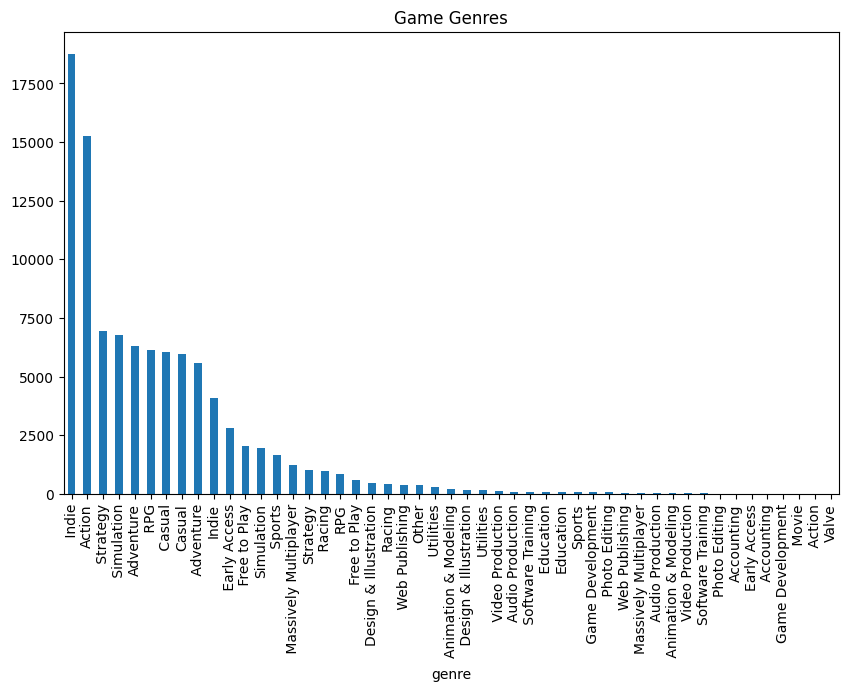

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

map_df = data.copy()

map_df['genre'] = map_df['genre'].str.split(',')
data_exploded = map_df.explode('genre')
counts = data_exploded['genre'].value_counts()

# Create a pie chart
ax = counts.plot(kind='bar', legend=False)

# Add some formatting
ax.set_ylabel('')
ax.set_title('Game Genres')
plt.show()

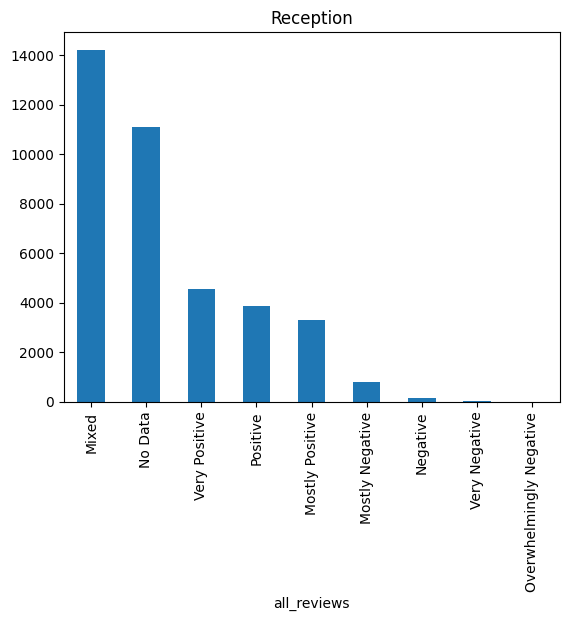

In [4]:
# Create a pie chart
ax = data['all_reviews'].value_counts().plot(kind='bar', legend=False)

# Add some formatting
ax.set_ylabel('')
ax.set_title('Reception')
plt.show()

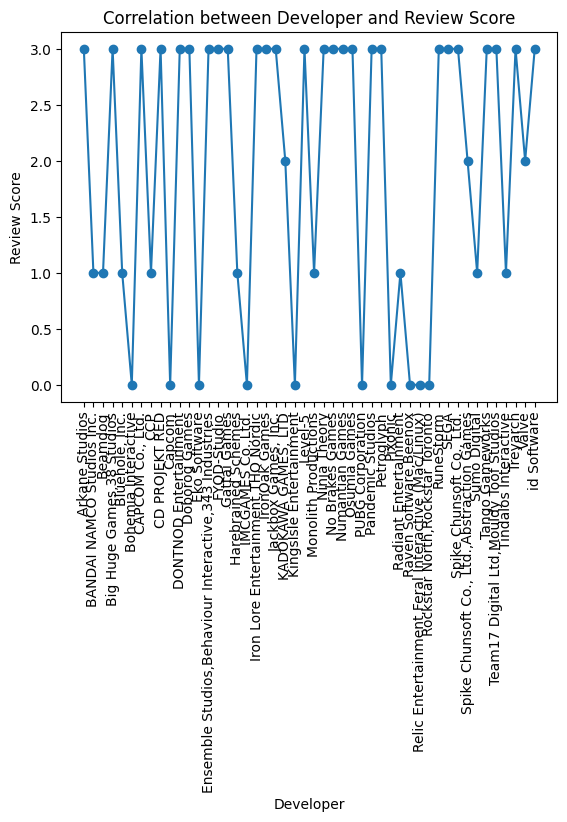

<Figure size 1000x600 with 0 Axes>

In [5]:
gf = data.head(50)
grouped_df = gf[['developer', 'review_scores']].groupby('developer').mean()

plt.plot(grouped_df.index, grouped_df['review_scores'], marker='o')
plt.xlabel('Developer')
plt.xticks(rotation = 90)
plt.ylabel('Review Score')
plt.title('Correlation between Developer and Review Score')
plt.figure(figsize=(10,6))

plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from IPython.display import display

df = data.head(20000)
# df = data.copy()

df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.replace('[^\w\s]','')

# select a game to use as input
input_game = 'dayz'

indices = pd.Series(df.index, index=df['name'])
idx = indices[input_game.lower()]

# feature extraction
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
# df['features'] = df.apply(lambda x: ' '.join([x['name'], x['developer'], x['publisher'], x['popular_tags'], x['genre']]), axis=1)
df['features'] = df.apply(lambda x: ' '.join([x['name'], x['desc_snippet'], x['popular_tags'], x['genre']]), axis=1)

tfidf_matrix = tfidf.fit_transform(df['features'])

# build the model
cosine_similarities = linear_kernel(tfidf_matrix)

# # evaluate the model
sim_scores = list(enumerate(cosine_similarities[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:11]
game_indices = [i[0] for i in sim_scores]
recommendations = data.iloc[game_indices]

# create a new dataframe with the recommended games and their similarity scores
output_df = pd.DataFrame(columns=['name', 'similarity_score', 'developer', 'popular_tags', 'genre'])
output_df['name'] = recommendations['name']
output_df['similarity_score'] = [i[1] for i in sim_scores]
output_df['developer'] = recommendations['developer']
output_df['publisher'] = recommendations['publisher']
output_df['popular_tags'] = recommendations['popular_tags']
output_df['genre'] = recommendations['genre']

# print the table of recommendations
print("Recommendations for", input_game)
print("---------------------------")
display(output_df)

Recommendations for dayz
---------------------------


,name,similarity_score,developer,popular_tags,genre,publisher
4630,SURVIVAL,0.213280,TB Games,"Early Access, Survival, Open World, Multiplaye...","Action, Adventure, Indie, Massively Multiplaye...","TB Games,TB Games"
432,Miscreated,0.174493,Entrada Interactive LLC,"Survival, Open World, Multiplayer, Zombies, Po...","Action, Adventure, Indie, Massively Multiplaye...","Entrada Interactive LLC,Entrada Interactive LLC"
20934,ARK: Survival Evolved Season Pass,0.155394,"Studio Wildcard,Instinct Games,Efecto Studios,...","Action, Adventure, Massively Multiplayer, Surv...","Action, Adventure, Indie, Massively Multiplaye...",
17836,Survival: Supporter Pack DLC,0.146905,TB Games,"Action, Adventure, Massively Multiplayer, Indi...","Action, Adventure, Indie, Massively Multiplaye...",
3901,New Dawn,0.142439,e-visualsoft,"Early Access, Early Access, Survival, Massivel...","Adventure, Indie, Massively Multiplayer, RPG, ...","e-visualsoft,e-visualsoft"
14125,The Art of Shelter,0.137674,Might and Delight,"Adventure, Massively Multiplayer, Indie","Adventure, Indie, Massively Multiplayer",
2380,Survarium,0.135559,Vostok Games,"Early Access, Free to Play, Survival, Multipla...","Action, Free to Play, Massively Multiplayer, R...","Vostok Games,Vostok Games"
5214,Survival: Last Day,0.135032,BloodMoon Games,"Survival, Multiplayer, Open World, Crafting, A...","Action, Adventure, Indie, RPG","BloodMoon Games,BloodMoon Games"
20956,Naval Action - Painter,0.132559,Game-Labs,"Strategy, Action, Adventure, Massively Multipl...","Action, Adventure, Indie, Massively Multiplaye...","Game-Labs,Game-Labs"
14726,Tower Unite - Original Soundtrack,0.132365,William Smith,"Action, Adventure, Massively Multiplayer, Indi...","Action, Adventure, Casual, Indie, Massively Mu...","PixelTail Games,PixelTail Games"
